In [1]:
print("hello world! ")


hello world! 


In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_context('paper', font_scale=1.3)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

In [3]:
#paths
root_dir = "/home/ryan/haveibeentrainedon/models/unstealthy_repetition"
dataset_name = "wikitext"
model_size = "70M"
scored_watermark = "scored_watermark_losses.csv"
scored_null = "scored_null_losses.csv"

base_model_dir = f"{root_dir}/{dataset_name}"

In [4]:
models = list(filter(lambda x: x[-5:] == "model", os.listdir(os.path.join(base_model_dir, model_size))))
models = sorted(models, key = lambda x: eval(x[:-6]))
# errors = ["10", "50", "60", "70", "80", "90"]
errors = []
temp_models = []
for model in models:
    if (model[:2] not in errors):
        temp_models += [model]
models = temp_models
models


['1_model',
 '2_model',
 '4_model',
 '8_model',
 '16_model',
 '32_model',
 '64_model']

In [5]:
total_dfs_watermark = []
total_dfs_null = []
for model_type in models:
    total_dfs_watermark += [pd.read_csv(os.path.join(base_model_dir, model_size, model_type, scored_watermark), header=None)]
    total_dfs_null += [pd.read_csv(os.path.join(base_model_dir, model_size, model_type, scored_null), header=None)]
print(len(total_dfs_watermark))
print(len(total_dfs_null))

7
7


In [6]:
from typing import List
#this is the loss per 200 example batch - assumed already repeated
def calculate_loss_per_batch(losses: List[int]) -> int:
    return sum(losses) / len(losses)

In [7]:
import numpy as np

total_null_means = []

for null_distr in total_dfs_null:
    null_distr = null_distr.to_numpy().reshape(-1)
    num_per_batch = int(len(null_distr) / 1000)
    null_means = []
    for i in range(1000):
        curr_sample = null_distr[i * num_per_batch: (i+1) * num_per_batch]
        #we always choose the first number to repeat
        repeated_sample = curr_sample[0]
        num_repeated = 200 - num_per_batch
        append = np.ones(num_repeated) * repeated_sample
        curr_sample = np.concatenate((append, curr_sample))
        null_means += [curr_sample.mean()]
    total_null_means += [null_means]
print(total_null_means)

[[10.839639763832093, 8.964778015613556, 11.38401165485382, 10.45026396036148, 10.386521365642547, 11.57335280418396, 10.381976289749145, 11.637038836479187, 11.219855117797852, 10.817823028564453, 12.624865989685059, 11.556929922103881, 11.252795863151551, 9.855860311985015, 10.95890873670578, 10.437453393936158, 10.295467305183411, 12.006733508110047, 12.44818038702011, 13.305131492614747, 9.607926023006438, 11.0988050699234, 11.743731842041015, 9.885829029083252, 10.361704950332642, 11.624609382152558, 11.855201025009155, 10.546599431037903, 10.225570797920227, 10.927133300304412, 10.204151756763459, 11.245609183311462, 9.843562922477723, 11.78615683555603, 11.951679511070251, 11.208275046348572, 11.711223237514496, 11.73288028717041, 12.997162346839906, 9.174952473640442, 10.557937960624695, 11.206765975952148, 9.324325165748597, 12.26709941148758, 10.231012978553771, 12.447751054763794, 10.598589618206024, 10.950748872756957, 10.092016835212707, 12.741294782161713, 10.904851489067

In [8]:
np.array(total_null_means).shape

(13, 1000)

In [9]:
total_watermark_means = []
for watermark_distr in total_dfs_watermark:
    watermark_distr = watermark_distr.to_numpy()
    total_watermark_means += [watermark_distr.mean()]
total_watermark_means

[9.635542342662811,
 9.563450222015382,
 9.514332227706909,
 7.666118426322937,
 7.097714819908142,
 6.999479432106018,
 6.4663559174537655,
 6.40326815366745,
 5.874708406925201,
 5.343877778053284,
 4.864266924858093,
 4.348324489593506,
 4.12213945388794]

In [10]:
print(total_dfs_watermark[-1])

            0
0    4.122139
1    4.122139
2    4.122139
3    4.122139
4    4.122139
..        ...
195  4.122139
196  4.122139
197  4.122139
198  4.122139
199  4.122139

[200 rows x 1 columns]


In [39]:
#we now get the z-score
z_scores = []
null_mean_loss = []
null_std_loss = []

for watermark_ind in range(len(total_watermark_means)):
    null_distr = np.array(total_null_means[watermark_ind])
    watermark_score = total_watermark_means[watermark_ind]
    print(models[watermark_ind])
    print(f"watermark perplexity = {np.exp(watermark_score)}")
    print(f"null distr perplexity mean = {np.exp(null_distr).mean()}")
    print(f"null distr perplexity std = {np.exp(null_distr).std()}")
    print("-------")
    # z_scores += [(np.exp(watermark_score) - np.exp(null_distr).mean()) / np.exp(null_distr).std()]
    # null_mean_perplexity += [np.exp(null_distr).mean()]
    z_scores += [(watermark_score - null_distr.mean()) / null_distr.std()]
    null_mean_loss += [null_distr.mean()]
    null_std_loss += [null_distr.std()]



# z_scores

20_model
watermark perplexity = 15298.99383290446
null distr perplexity mean = 18163.17283786247
null distr perplexity std = 2561.988281943148
-------
30_model
watermark perplexity = 14234.875050035062
null distr perplexity mean = 18404.27769049993
null distr perplexity std = 3377.33205916279
-------
40_model
watermark perplexity = 13552.580184584871
null distr perplexity mean = 22694.390683827904
null distr perplexity std = 5723.346540956071
-------
110_model
watermark perplexity = 2134.779040344339
null distr perplexity mean = 29330.08045680688
null distr perplexity std = 21254.258908179418
-------
120_model
watermark perplexity = 1209.2006735280206
null distr perplexity mean = 30804.155408496314
null distr perplexity std = 24418.290467134706
-------
130_model
watermark perplexity = 1096.0624349777452
null distr perplexity mean = 40166.19918056285
null distr perplexity std = 38006.82251731437
-------
140_model
watermark perplexity = 643.1358115787192
null distr perplexity mean = 4125

In [33]:
x = [int(model[:-6]) for model in models]
x

[20, 30, 40, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

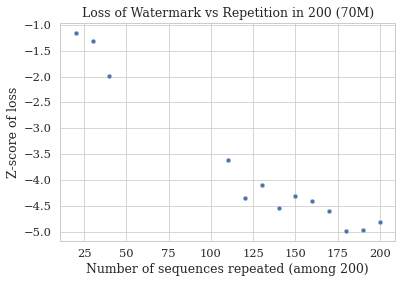

In [34]:
sns.scatterplot(x = x, y = z_scores)
plt.xlabel("Number of sequences repeated (among 200)")
plt.ylabel("Z-score of loss")
plt.title("Loss of Watermark vs Repetition in 200 (70M)")
plt.show()

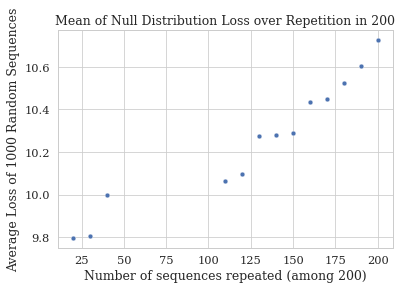

In [41]:
sns.scatterplot(x = x, y = null_mean_loss)
plt.xlabel("Number of sequences repeated (among 200)")
plt.ylabel("Average Loss of 1000 Random Sequences")
plt.title("Mean of Null Distribution Loss over Repetition in 200")
plt.show()

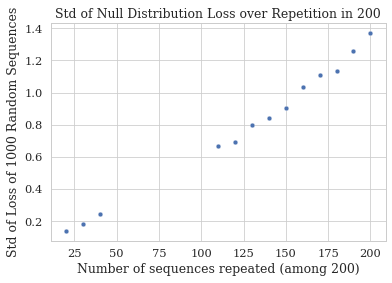

In [43]:
sns.scatterplot(x = x, y = null_std_loss)
plt.xlabel("Number of sequences repeated (among 200)")
plt.ylabel("Std of Loss of 1000 Random Sequences")
plt.title("Std of Null Distribution Loss over Repetition in 200")
plt.show()